In [14]:
#%% Import packages

import matplotlib.pyplot as plt
import copy
import pandas as pd
import numpy as np

from climada.entity import Entity
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.hazard import Hazard

import steps_functions as sfc

import submodules.gen_exp as gen_exp

## Code structure

Based on unique CLIMADA objects (exposure, measure, … ) at
- Given years: defined objects by the user at given years
- Available years: derived unique objects
- Pathway years: the year we estimate the risk metric

### Inital parameters

In [15]:
START_YEAR = 2020
FUTURE_YEAR = 2070


## Step 1 - Organize the Exposure objects

### Create a exposure dictionary

In [16]:
# Parameters
# Input to function
year_0 = START_YEAR
year_1 = year_0+5
year_2 = year_1+5
year_3 = year_2 + 25



ent_USD = Entity.from_excel(ENT_DEMO_TODAY).exposures
ent_USD.gdf['value_unit'] = 'USD'
ent_PEOPLE = Entity.from_excel(ENT_DEMO_TODAY).exposures
ent_PEOPLE.gdf['value_unit'] = 'PEOPLE'

people_growth_rate = 0.01
usd_growth_rate = 0.02

# Build the exposure dictionary
exp_dict = {}
exp_dict[year_0] = [ent_USD, ent_PEOPLE]
# Give value_unit to the exposure 'USD'
exp_dict[year_1] = [copy.deepcopy(ent_USD), copy.deepcopy(ent_PEOPLE)]
exp_dict[year_1][0]
exp_dict[year_1][0].gdf.value *= (1+people_growth_rate)**(year_1-year_0)
exp_dict[year_1][1].gdf.value *= (1+usd_growth_rate)**(year_1-year_0)
# Give value_unit to the exposure 'USD'
exp_dict[year_2] = [copy.deepcopy(ent_USD), copy.deepcopy(ent_PEOPLE)]
exp_dict[year_2][0].gdf.value *= (1+people_growth_rate)**(year_2-year_0)
exp_dict[year_2][1].gdf.value *= (1+usd_growth_rate)**(year_2-year_0)
# Give value_unit to the exposure 'USD'
exp_dict[year_3] = [copy.deepcopy(ent_USD)]
exp_dict[year_3][0].gdf.value *= (1+usd_growth_rate)**(year_3-year_0)
# Add a new exposure point with slightly different location
exp_dict[year_2][0].gdf.iloc[-2, exp_dict[year_3][0].gdf.columns.get_loc('longitude')] = exp_dict[year_3][0].gdf.iloc[-2, exp_dict[year_3][0].gdf.columns.get_loc('longitude')] + 1.0


# Remove second item of the list in year_3
#exp_dict[year_0] = [exp_dict[year_0][0]]

### Generate expsoure function

The missing unique exposure IDs in the year 2020 for exposure type USD are:
     latitude  longitude
50  26.348015 -79.241305
The missing unique exposure IDs in the year 2025 for exposure type USD are:
     latitude  longitude
50  26.348015 -79.241305
The missing unique exposure IDs in the year 2030 for exposure type USD are:
     latitude  longitude
48  26.348015 -80.241305
The missing unique exposure IDs in the year 2055 for exposure type USD are:
     latitude  longitude
50  26.348015 -79.241305
The number of exposure objects for USD is 4
The number of exposure objects for PEOPLE is 3
The difference in the gdf for USD in year 2055 is:
Empty DataFrame
Columns: [latitude, longitude, value, deductible, cover, impf_TC, Value_2010, value_unit]
Index: []
Empty DataFrame
Columns: [latitude, longitude, value, deductible, cover, impf_TC, Value_2010, value_unit]
Index: []


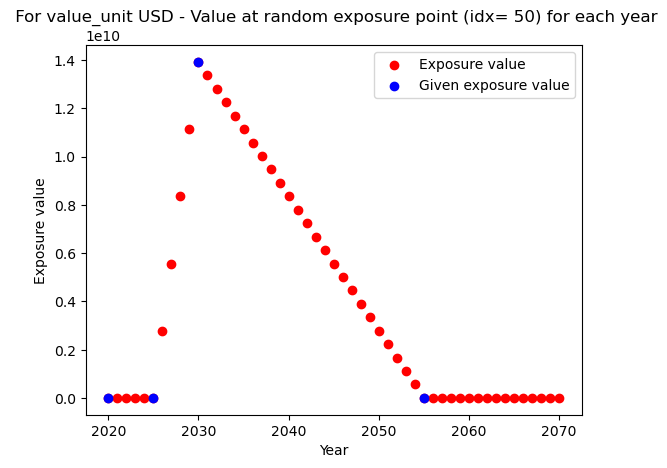

ValueError: The exposure point is not in the exposure set

In [20]:

# Parameters
growth_rate = 0.08
year_future = FUTURE_YEAR
intr_param = 1

#exp_avail_dict, exp_given_dict, exp_multipl_dict, exp_intrpl_dict = sfc.generate_exp_sets(exp_dict, intr_param,  future_year=year_future, growth_rate=0.02)

# Generate the exposure 
exp_avail_dict, exp_given_mod_dict, exp_multipl_dict, exp_intrpl_dict, exp_unique_ids_dict = gen_exp.generate_exp_sets(exp_dict, intr_param,  future_year=year_future, growth_rate=0.02)

# Plot the exposure
exp_idx = 50
gen_exp.plot_exp_value(exp_avail_dict, exp_given_mod_dict, exp_multipl_dict, future_year=year_future, exp_point=exp_idx)

## Step 2 - Create the hazard container

In [5]:
# Parameters
# Input to function
year_0 = START_YEAR
year_1 = year_0+15
year_2 = year_1+5
year_3 = year_2 + 5

# Hazard set TC
haz_dict = {}
haz_dict[year_0] = Hazard.from_hdf5(HAZ_DEMO_H5)
haz_dict[year_1] = copy.deepcopy(haz_dict[year_0])
haz_dict[year_1].intensity *= 1.5
haz_dict[year_2] = copy.deepcopy(haz_dict[year_0])
haz_dict[year_2].intensity *= 2
haz_dict[year_3] = copy.deepcopy(haz_dict[year_0])
haz_dict[year_3].intensity *= 3

### Generate hazard attributes

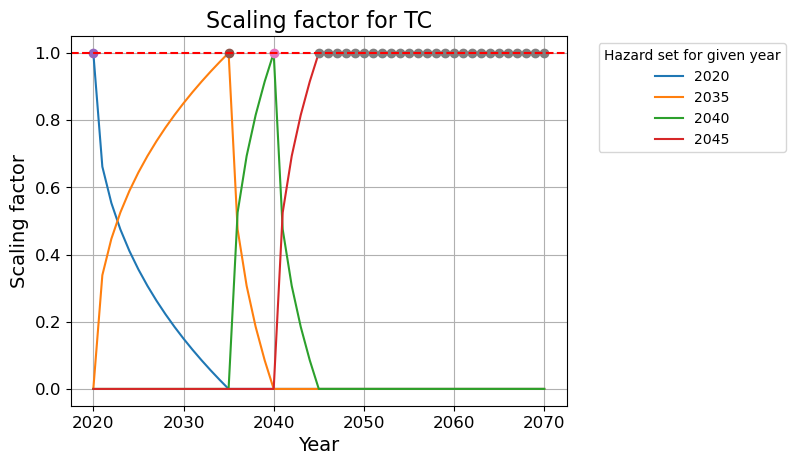

In [6]:
# Parameters
year_future = FUTURE_YEAR
intr_param = 0.4

haz_avail_dict, haz_given_dict, haz_param_dict = sfc.generate_haz_sets(haz_dict, intr_param, future_year=FUTURE_YEAR)

## Step 3 - Create the impact fun sets active df

In [7]:
# Set the impact functions per year
imp_fun_set_dict = {} 
for year in [year_0, year_0+4, year_0+10]:
    imp_fun_set_dict[year] = Entity.from_excel(ENT_DEMO_TODAY).impact_funcs

impfs_avail_dict, impfs_given_dict, impfs_active_df = sfc.generate_impfs_active_df(imp_fun_set_dict, future_year=FUTURE_YEAR)

## Step 4 - Create the adapdation measures active df

In [8]:
# Define parameter adaptation measure dictionary
meas_dict = {}
for year in [year_0, year_0+3, year_0+12]:
    measure_set = Entity.from_excel(ENT_DEMO_TODAY).measures
    meas_dict[year] = copy.deepcopy(measure_set)
# Define parameter adaptation measure off
meas_inactive_years_dict = {'Seawall': [year_0+5, year_0+10], 'Building code': [year_0+1, year_0+12]}

# Generate the measure active dataframe
meas_avail_dict, meas_given_dict, meas_active_df = sfc.generate_meas_df(meas_dict, future_year= FUTURE_YEAR, meas_inactive_years_dict=meas_inactive_years_dict)

## Step 5 - Create the impact mapping objects

- Remember, for every given of an exposure, adaptation measure, impact_function_set and TC there is a unique impact object 
- Remember that if a measure is inactive it is the same as having no measure to sample from. 
    - For combinations of measure you then need to exclude sampling from that object.

### Generate the measure impact mapping

In [9]:
imp_meas_map_year_df, imp_meas_unique_df = sfc.generate_imp_meas_df(exp_avail_dict, haz_avail_dict, impfs_active_df, exp_multipl_dict, haz_param_dict, meas_avail_dict, meas_active_df, incl_insurance = True)

### Generate the combo impact mapping

In [10]:
# Define the combons of measures
combo_dict = {'Combo 1': ['Building code', 'Mangroves'], 'Combo 2': ['Beach nourishment', 'Seawall' ]}

imp_combo_map_df, imp_combo_unique_df = sfc.generate_imp_combo_df(imp_meas_map_year_df, combo_dict = combo_dict)

## Step 6 - Create the unique impact objects

### Very important!!! If the measure involves changing the exposure points then the realtive impact matrix must be modified

In [11]:

imp_calc_params_kwargs = {'save_mat': True, 'assign_centroids': True, 'ignore_cover': False, 'ignore_deductible': False}

imp_abs_dict, imp_rel_dict = sfc.generate_imp_obj_dict(imp_meas_unique_df, exp_avail_dict, haz_avail_dict, impfs_avail_dict, meas_avail_dict, calc_rel_imp = True, imp_calc_params_kwargs= imp_calc_params_kwargs)

## Step 7 - Create the combined measures impact objects

- Make possible to calcualte the aboslute or relative impact marix based on either 
    - Capped sum of impacted
    - Convolution of impact measures 

## Step 8 - Sample the event IDs

In [13]:
# Decide on sampling method
# Bayesian, or frequency based
sample_method = 'frequency' # 'bayesian' or 'frequency'

# Number of samples
n_samples = 100

sampled_eventIDs_dict, haz_Bayesian_select_dict = sfc.generate_sample_eventIDs(haz_avail_dict, haz_param_dict, future_year=FUTURE_YEAR, n_samples=n_samples, sample_method=sample_method)

## Step 9 - Get the unique exposure groups data frame

In [ ]:
Based on the columns in the exposure files make data frames that creates a group ID and the unique column combinations and then in one of the columns sets the exposure IDs in a list such that it beceomes easy to aggreagte in the same pmatrix

## Step 10 - Calculate the simulated exposure values and impacts over time
ASSUME recovyrey rate 1 year for now and only sampel the impacts aggregated per group 


1. sim_imp_per_group_per_event
2. sim_imp_per_group_per_year
3. sim_exp_cent_per_event_value_matrix and sim_exp_cent_per_event_impact_matrix
    - store in dictioany for each measure
    - rows are simualted trajectories and columns are path years and cells are a list with inner list being an event and an inner list being the exposure value of impact per ccentroid list
4. sim_tot_value_per_group_event_impact_matrix and sim_tot_imp_per_group_event_impact_matrix
5. sim_tot_value_per_year_impact_matrix and sim_tot_imp_per_year_impact_matrix
6. sim_exp_cent_per_traj_value_vector and sim_exp_cent_per_traj_impact_vector 